# **IEOR E4650  Business Analytics (Fall 2019)**

##**Lecture 7: Poisson Model with Unobserved Heterogeneity**

In this lecture, we discuss how to model heterogeneity for a count model. 

Learning objective:

* Understand the idea of unobserved heterogeneity
* Understand how to estimate a count model with unobserved heterogeneity
* Understand how to use the model for prediction



##Unobserved Heterogeneity

The previous model did not give a good fit. The main issue with the model is that it assumes that every poisson process follows the same $\lambda$.

However, in reality, customers might have different $\lambda$. For example, some customers might go online very infrequently, leading to fewer exposures  (low $\lambda$). However, some customers might go online very frequently, leading to more exposures (high $\lambda$). This is called heterogeneity. 

If the data tells us whether the customers log online frequently or not, we can model them separately. However, the data is not there. Thus, we will need to rely on the data to dig out this information. Since we are not observing the segmentation directly, this is also called modeling "unobserved" heterogeneity.



## Mixture Model

Mixture model is a model that is commonly used for modeling of unobserved heterogeneity.


### General Scope of a mixture model


the likelihood is modeled as 

$Likelihood=likelihood_1*p+likelihood_2*(1-p)$

Here, $likelihood_1$ measures how likely it is to observe an outcome if the outcomes belongs to group 1. $likelihood_2$ will measures how likely it is to observe an outcome if the outcomes belongs to group 2. Since we do not know which group an observation belongs to, we use $p$ to model the probability for an observation to belong to the first segment. This $p$ will be a parameter we estimate.


<div>
<img src="http://tinyheero.github.io/assets/mixture-model-mixtools-1.png
" width="450"/>
</div>


[Source: Fong Chun Chan's Blog]

An example above shows a mixture of two distributions. 

### Estimation of Mixture model

The estimation of the parameters for a mixture model stays the same. The only thing changes is the way we compute the individual likelihood function.

Our individual likelihood function will be a weighted average between two Poisson PMFs:

$PMF_{poisson}(y_i|\lambda_1) p+ PMF_{poisson}(y_i|\lambda_2) (1-p)$

$PMF_{poisson}(y_i|\lambda_1)$ is the PMF of a Poisson distribution with $\lambda_1$ at $y_i$. Similarly, $PMF_{poisson}(y_i|\lambda_2)$ is the PMF of a Poisson distribution with $\lambda_2$ at $y_i$. 

We will estimate three parameters：

$\lambda_1$: The expected number of exposures if an observation belongs to category 1.

$\lambda_2$: The expected number of exposures if an observation belongs to category 2.

$p$: the probability of an observation belonging to category 1.

Here, $p$ is a probability and should be constraint before 0 and 1. To ensure that we are still running an uncontrained optimization, we use $p=\frac{exp(\beta)}{1+exp(\beta)}$ instead of $p$. You can see that there is one-on-one relationship between $\beta$ and $p$. Also estimating the unconstrained $\beta$ allows us to restrict our $p$ between 0 and 1.


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link="https://drive.google.com/open?id=1pjdoOKuczV8Zc6Zw8-yUh6q2tqogN-xt"
_,id=link.split("=")
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('myfile.csv')  
import pandas as pd
import numpy as np
Exposure = pd.read_csv('myfile.csv')
Exposure.head(10)

import matplotlib.pyplot as plt

import scipy.stats as spst
from scipy.optimize import minimize
import scipy.special as spsp



In [0]:

Exposures=Exposure["Exposures"].values

def neg_LL(betas):
  lmbda1=np.exp(betas[0])
  lmbda2=np.exp(betas[1])
  p=np.exp(betas[2])/(np.exp(betas[2])+1)
  #individual likelihood
  likelihood1=spst.poisson.pmf(Exposures,lmbda1)
  likelihood2=spst.poisson.pmf(Exposures,lmbda2)
  likelihood=likelihood1*p+likelihood2*(1-p)

  #individual log likelihood
  ind_LL=np.log(likelihood)
 
  #joint log likelihood
  return  -np.sum(ind_LL)




In [0]:
guess=np.random.rand(3)
betas=minimize(neg_LL,guess,method="BFGS").x
lmbda1=np.exp(betas[0])
lmbda2=np.exp(betas[1])
p=np.exp(betas[2])/(np.exp(betas[2])+1)

print(lmbda1,lmbda2,p)

10.586064089575979 0.6021938213502007 0.1920704230748303


###Again, checking model fit


In [0]:
Exposure

,Cookie_ID,Exposures
0,1,0
1,2,0
2,3,3
3,4,49
4,5,4
5,6,1
6,7,5
7,8,0
8,9,7
9,10,27


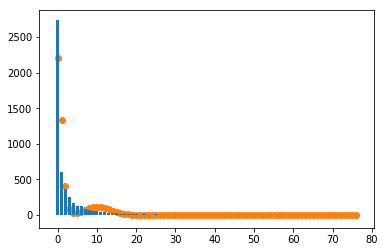

In [0]:
x=np.arange(0, np.max(Exposures+1))
pmf=spst.poisson.pmf(x,lmbda1)*p+spst.poisson.pmf(x,lmbda2)*(1-p)
prediction= pmf*5000

Tally=Exposure.groupby(["Exposures"]).count()
plt.bar(Tally.index.values,Tally.iloc[:,0].values)
plt.scatter(x,prediction)

###Market Analysis

Let's revisit our original question. If we have the exposure $t$ times long, what is the expected number of exposures if we have 5000 customers?

This time, the probability for 

$P(y)=P(y|t\lambda_1)p+P(y|t\lambda_2)(1-p)=\frac{exp(-t\lambda_1)(t\lambda_1)^y}{y!}p+\frac{exp(-t\lambda_2)(t\lambda_2)^y}{y!}(1-p)$

In [0]:
#time 1 unit
size=5000
likelihood1=spst.poisson.pmf(Exposures,lmbda1)
likelihood2=spst.poisson.pmf(Exposures,lmbda2)
likelihood=likelihood1*p+likelihood2*(1-p)
(likelihood*size)[0:10]


array([2.21217165e+03, 2.21217165e+03, 8.53115341e+01, 6.49901451e-15,
       2.48178875e+01, 1.33239832e+03, 2.83413207e+01, 2.21217165e+03,
       7.17379139e+01, 1.03707549e-02])

In [0]:
#time 3 units
size=5000
likelihood1=spst.poisson.pmf(Exposures,lmbda1*3)
likelihood2=spst.poisson.pmf(Exposures,lmbda2*3)
likelihood=likelihood1*p+likelihood2*(1-p)
(likelihood*size)[0:10]


array([6.63368985e+02, 6.63368985e+02, 6.51893324e+02, 9.92774798e-01,
       2.94424593e+02, 1.19843009e+03, 1.06380404e+02, 6.63368985e+02,
       8.26670938e+00, 5.04830985e+01])

### Posterior analysis:

The Good thing about the mixture model is that we can conduct a posterior analysis on the individual level. The question is if we observe a person had $x$ exposures, can we know better about the expected number of exposures for this person?

Remember that we will not able to do so for a simple Poisson model, because everyone is supposed to follow the same Poisson process. However, in the current case, once we know how many exposures is received by a person, we can use Bayes theorem to update the probability of this person belong to each segment, which, in return, can help us update the expected number of $\lambda$.


$$\text{P(Segment1|Likelihood)}=\frac{Likelihood_1*p}{Likelihood_1*p+Likelihood_2*(1-p)}$$


In [0]:
#p(y|lambda1)
likelihood1=spst.poisson.pmf(Exposures,lmbda1)
#p(y|lambda2)
likelihood2=spst.poisson.pmf(Exposures,lmbda2)
#p(y|lambda1)*p+p(y|lambda2)*(1-p)
likelihood=likelihood1*p+likelihood2*(1-p)
#p-posterior
p_post=likelihood1*p/likelihood
Exposure=Exposure.assign(p_post=p_post)
Exposure


,Cookie_ID,Exposures,p_post
0,1,0,0.000011
1,2,0,0.000011
2,3,3,0.056235
3,4,49,1.000000
4,5,4,0.511592
5,6,1,0.000193
6,7,5,0.948490
7,8,0,0.000011
8,9,7,0.999824
9,10,27,1.000000


After that, we can update $E(\lambda)$ for each customer using

$\lambda_1 p+\lambda_2(1-p)$

In [0]:
#Exposure for the customer given observing the customer 

Exposures_post=lmbda1*p_post+lmbda2*(1-p_post)
Exposure=Exposure.assign(Exposures_post=Exposures_post)
Exposure

 

,Cookie_ID,Exposures,p_post,Exposures_post
0,1,0,0.000011,0.602303
1,2,0,0.000011,0.602303
2,3,3,0.056235,1.163636
3,4,49,1.000000,10.586064
4,5,4,0.511592,5.709857
5,6,1,0.000193,0.604119
6,7,5,0.948490,10.071792
7,8,0,0.000011,0.602303
8,9,7,0.999824,10.584310
9,10,27,1.000000,10.586064


###Zero-inflated Poisson

Now, let's put another assumption on the model. What if one segment of consumers simply do not get to see the advertisement ($\lambda=0$) while the other segment of consumers will have their exposure following a Poisson process with $\lambda$?

In this case, we will need to set $\lambda=0$ for one segment. Thus, we will need to estimate only one $\lambda$, and $p$, the probability of belonging to one segment. 

The likelihood will follow:

$PMF_{poisson}(y_i|\lambda_1=0) p+ PMF_{poisson}(y_i|\lambda_2) (1-p)$

This model is also called zero-inflated Poisson regression.

In [0]:

Exposures=Exposure["Exposures"].values

def neg_LL(betas):
  #segment that will never have exposures
  lmbda1=0
  #segment that will follow a poisson process with lmbda2 rate
  lmbda2=np.exp(betas[0])
  p=np.exp(betas[1])/(np.exp(betas[1])+1)
  #individual likelihood
  likelihood1=spst.poisson.pmf(Exposures,lmbda1)
  likelihood2=spst.poisson.pmf(Exposures,lmbda2)
  likelihood=likelihood1*p+likelihood2*(1-p)
  #individual log likelihood
  ind_LL=np.log(likelihood)
  #joint log likelihood
  return  -np.sum(ind_LL)

guess=np.random.rand(2)
betas=minimize(neg_LL,guess,method="BFGS").x
lmbda1=0
lmbda2=np.exp(betas[0])
p=np.exp(betas[1])/(np.exp(betas[1])+1)

print(lmbda1,lmbda2,p)


0 5.543147096721757 0.5454206865718594


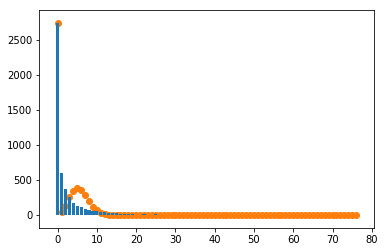

In [0]:
x=np.arange(0, np.max(Exposures+1))
pmf=spst.poisson.pmf(x,lmbda1)*p+spst.poisson.pmf(x,lmbda2)*(1-p)
prediction= pmf*5000

Tally=Exposure.groupby(["Exposures"]).count()
plt.bar(Tally.index.values,Tally.iloc[:,0].values)
plt.scatter(x,prediction)

##Continuous Unobserved Heterogeneity

We can potentially add many segments to a mixture model. However, as we add more segments, we will need to estimate more parameters, which might make the model hard to converge.


Sometimes, it makes more sense to assume that every customer has different parameter values. In other words, we will assume a parameter that bears heterogeneity following a continuous distribution.



###Constructing the likelihood function

It can be useful to assume that all the customers have different $\lambda$. It is common to assume that $\lambda$ follows a Gamma distribution ($\sim Gamma(\gamma, \alpha)$).

Gamma distribution is a continuous distribution and has the following PDF:


$$f(\lambda)=\frac{\alpha^\gamma}{\Gamma(\gamma)}\lambda ^{\gamma-1} exp(-{\alpha\lambda})$$.

where $\lambda>0$. $\alpha$ and $\gamma$ are both positive parameters. 

$E(\lambda)=\frac{\gamma}{\alpha}$, while $Var(\lambda)=\frac{\gamma}{\alpha^2}$



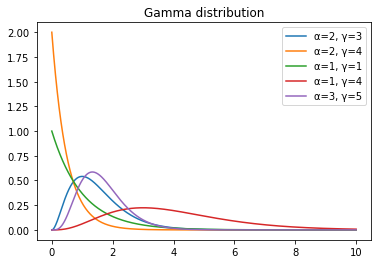

In [0]:
def gamma_pdf(lmbda,alpha,gamma):
  pdf=alpha**gamma/spsp.gamma(gamma)*lmbda**(gamma-1)*np.exp(-alpha*lmbda)
  return pdf

lmbda=np.linspace(0,10,1000)
plt.plot(lmbda, gamma_pdf(lmbda,2,3), label="\u03B1=2, \u03B3=3")
plt.plot(lmbda, gamma_pdf(lmbda,2,1), label="\u03B1=2, \u03B3=4")
plt.plot(lmbda, gamma_pdf(lmbda,1,1), label="\u03B1=1, \u03B3=1")
plt.plot(lmbda, gamma_pdf(lmbda,1,4), label="\u03B1=1, \u03B3=4")
plt.plot(lmbda, gamma_pdf(lmbda,3,5), label="\u03B1=3, \u03B3=5")
plt.legend(loc="best")
plt.title("Gamma distribution")
plt.show()

There are many reasons we choose Gamma distribution: 

(1) Gamma distribution ranges from 0 and $\infty$, which fits the range for $\lambda$

(2) Gamma distribution has a very flexible shape even though it only has two parameters.

(3) We can derive the closed-form solution for the likelihood.

Since do not observe the $\lambda$ for each person, we will need to integrate $\lambda$ out. 

$likelihood=\int P(y|\lambda)f(\lambda) d\lambda=∫\frac{\lambda^y exp(-\lambda)}{y!} \times \frac{\alpha^\gamma}{\Gamma(\gamma)}\lambda ^{\gamma-1} exp(-{\alpha\lambda}) dλ=\frac{\Gamma(\gamma+y)}{\Gamma(\gamma)\Gamma(y+1)}(\frac{1}{\alpha+1})^y (\frac{\alpha}{\alpha+1})^\gamma $

The integration result gives the PMF of a distribution called "negative binomial distribution". Thus,this regression is also called NBD regression.

For an NBD distribution, the mean is equal to $\gamma/\alpha$, while the variance is equal to **$\gamma(1+\alpha)/\alpha^2$.**

In [0]:
#Overdispersion
mean=np.mean(Exposures)
#ddof=1 because we are calculating the sample variance
variance=np.var(Exposures,ddof=1)
print(mean,variance)
#variance is much higher than mean

2.5198 26.676143188637727


In [0]:

def neg_LL(betas):
  #compute alpha, gamma
  alpha=np.exp(betas[0])
  gamma=np.exp(betas[1])
  #individual  likelihood
  ind_L=spsp.gamma(gamma+Exposures)/spsp.gamma(gamma)/spsp.gamma(Exposures+1)\
  *(1/(1+alpha))**Exposures*(alpha/(1+alpha))**gamma
  #individual log likelihoo
  ind_LL=np.log(ind_L)
  #joint log likelihood
  Joint_LL=np.sum(ind_LL)
  return -Joint_LL

guess=np.random.rand(2)
betas=minimize(neg_LL,guess,method="BFGS").x

#recover alpha, gamma
alpha=np.exp(betas[0])
gamma=np.exp(betas[1])

print(alpha,gamma)




0.10013714545553243 0.2523255516468372


###Model Fit

Again, let's take a look at the model fit

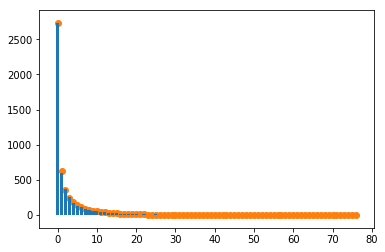

In [0]:
x=np.arange(0, np.max(Exposures+1))
PMF =spsp.gamma(gamma+x)/spsp.gamma(gamma)/spsp.gamma(x+1)\
  *(1/(1+alpha))**x*(alpha/(1+alpha))**gamma
prediction=  PMF*size
Tally=Exposure.groupby(["Exposures"]).count()
plt.bar(Tally.index.values,Tally.iloc[:,0].values)
plt.scatter(x,prediction)



### Market Analysis

Let's revisit the question: 

How do we now the number of customers having 0 exposures, 1, exposures, ... if the time window is $t$ times long?

It can be derived that 

$P(y)=\frac{\Gamma(\gamma+y)}{\Gamma(\gamma)\Gamma(y+1)}(\frac{t}{\alpha+t})^y (\frac{\alpha}{\alpha+t})^\gamma$





In [0]:
#1 unit long
x=np.arange(0, np.max(Exposures+1))
PMF =spsp.gamma(gamma+x)/spsp.gamma(gamma)/spsp.gamma(x+1)\
  *(1/(1+alpha))**x*(alpha/(1+alpha))**gamma
prediction=  PMF*size
prediction[0:10]

array([2731.09334986,  626.39884395,  356.52612997,  243.30691122,
        179.82150851,  139.01168569,  110.61266796,   89.80522021,
         74.00176149,   61.67782805])

In [0]:
#3 unit long
t=3
x=np.arange(0, np.max(Exposures+1))
PMF =spsp.gamma(gamma+x)/spsp.gamma(gamma)/spsp.gamma(x+1)\
  *(t/(t+alpha))**x*(alpha/(t+alpha))**gamma
prediction=  PMF*size
prediction[0:10]

array([2102.84218247,  513.46194264,  311.12567625,  226.04042257,
        177.8527064 ,  146.37177113,  123.99325537,  107.17215249,
         94.01769625,   83.42261441])

###Posterior Analysis


Let's assume that the $\lambda \sim Gamma(\gamma, alpha)$ on the market level.

If we observe a customer had $x$ exposures, we can update the distribution of $\lambda$ for this customer just like what we did for a mixture model.

$f(\lambda|x)=\frac{P(x|\lambda)g(\lambda)}{\int P(x|\lambda)g{\lambda} d\lambda}$

Again, this formula is based on Bayes theorem.

It can be derived that $\lambda|y \sim Gamma( \gamma+y, \alpha+1)$

Thus, $E(\lambda|x)=\frac{\gamma+y}{\alpha+1}$

In [0]:
Exposure_post_gamma=(gamma+Exposures)/(alpha+1)
Exposure.assign(Exposure_post_gamma=Exposure_post_gamma)

,Cookie_ID,Exposures,p_post,Exposures_post,Exposure_post_gamma
0,1,0,0.000011,0.602303,0.229358
1,2,0,0.000011,0.602303,0.229358
2,3,3,0.056235,1.163636,2.956291
3,4,49,1.000000,10.586064,44.769260
4,5,4,0.511592,5.709857,3.865269
5,6,1,0.000193,0.604119,1.138336
6,7,5,0.948490,10.071792,4.774246
7,8,0,0.000011,0.602303,0.229358
8,9,7,0.999824,10.584310,6.592201
9,10,27,1.000000,10.586064,24.771753


##Appendix:



1. distibution of $y$ when $\lambda$ becomes $t\lambda$ while assuming $\lambda \sim Gamma(\gamma, \alpha)$.

According to the property of Gamma distribution

if $\lambda \sim Gamma(\gamma, \alpha)$

we have $t \lambda \sim Gamma(\gamma, \alpha/t )$

Thus, we have 

$P(y)=\frac{\Gamma(\gamma+y)}{\Gamma(\gamma)\Gamma(y+1)}(\frac{1}{\alpha/t+1})^x (\frac{\alpha/t}{\alpha/t+1})^\gamma$

$=\frac{\Gamma(\gamma+y)}{\Gamma(\gamma)\Gamma(y+1)}(\frac{t}{\alpha+t})^y (\frac{\alpha}{\alpha+t})^\gamma$


2. Deriving the likelihood for Poisson-Gamma.

$likelihood=\int P(y|\lambda)f(\lambda) d\lambda=∫\frac{\lambda^y exp(-\lambda)}{y!} \times \frac{\alpha^\gamma}{\Gamma(\gamma)}\lambda ^{\gamma-1} exp(-{\alpha\lambda}) dλ$

$=\frac{\alpha^\gamma}{\Gamma(\gamma)y!} ∫ \lambda^{y+\gamma-1}exp(-\alpha \lambda) dλ$

$=\frac{\alpha^\gamma}{\Gamma(\gamma)y!}\frac{\Gamma(\gamma+y)}{(\alpha+1)^{(r+y)}}∫ \frac{(\alpha+1)^{(\gamma+y)}}{\Gamma(\gamma+y)}\lambda ^{\gamma+y-1} exp(-{(\alpha+1)\lambda}) dλ$

=$\frac{\alpha^\gamma}{\Gamma(\gamma)y!}\frac{\Gamma(\gamma+y)}{(\alpha+1)^{(r+y)}}$


$=\frac{\Gamma(\gamma+y)}{\Gamma(\gamma)\Gamma(y+1)}(\frac{1}{\alpha+1})^y (\frac{\alpha}{\alpha+1})^\gamma $




3. Derive posterior for $\lambda$ given y

$f(\lambda|y)=\frac{P(y|\lambda)g(\lambda)}{\int P(y|\lambda)g{\lambda} d\lambda}=\frac{\frac{eyp(\lambda)\lambda^y}{y!} \frac{\alpha^\gamma}{\Gamma(\gamma)}\lambda ^{\gamma-1} exp(-{\alpha\lambda})}{\frac{\Gamma(\gamma+y)}{\Gamma(\gamma)\Gamma(y+1)}(\frac{1}{\alpha+1})^y (\frac{\alpha}{\alpha+1})^\gamma}= \frac{(\alpha+1)^{\gamma+y}}{\Gamma(\gamma+y)}\lambda ^{\gamma+y-1} exp(-{(\alpha+1)\lambda}) $

It is nothing but the PDF of gamma distribution with $\alpha+1$ and $\gamma+y$

